# Datová integrace - Šlápněten na plyn pomocí AI
## Doplňující materiál k prezentaci<br>
Tento dokument je plně k dispozici účastníkům události [Datová Integrace 2.0: Odemkněte potenciál pro zvýšení vaší produktivity](https://hello.weareflo.com/event/sept21)
### Created by
Jan Barták <br>
FLO - Data Solutions <br>
Evropská 866 | Prague| 160 00<br>
[jan.bartak@weareflo.com](mailto:jan.bartak@weareflo.com)<br>
[www.weareflo.com](https://www.weareflo.com) | [LinkedIn](https://www.linkedin.com/in/jan-bart%C3%A1k-381b6612a/)

### Introduction
Tento Jupyter Notebook byl vytvořen za účelem prezentace využití nástrojů AI (konkrétně ChatGPT a OpenAI API platformy)<br> v úlohách spojených s datovou integrací, mezi které patří:
1. Generování fake dat
2. Explanatory data analysis
3. Kontrola datové kvality
4. Generování dokumentace

### Disclaimer
Cílem toho dokumentu není ukázat best practices.<br>
Proto přebírám kód tak, jak ho vygeneruje model a nesnažím se o žádný refactoring, nevkládat už jedno importované knihovny apod.<br>

## 0. Environment setup
Nejdříve je ale potřeba si připravit prostředí (Jupyter Notebook), v kterém budeme pracovat.<br>
Je potřeba importovat následující knihovny:
- os - interakce s operačním systémem (vytvářet složky, číst proměnné prostředí)
- openai - pro přístup k OpenAI API
- datetime - práce s daty a časy
- pandas - pro analýzu dat
- logging - logování informací
<br>
Pokud nějakou z knihoven nemáte nainstalovanou ve Vašem prostředí, spusťe příkaz:<br>
<code>pip install název_knihovny</code>

In [1]:
# Import libraries
import os
import openai
from datetime import datetime, timedelta
import pandas as pd
import logging

Následující buňka:
- nastavuje základní konfiguraci pro logování v Pythonu
- nastavuje API klíč pro knihovnu openai. Používá metodu os.getenv(), která vrací hodnotu proměnné prostředí se zadaným názvem ("OPENAI_API_KEY")
    - <b>vložte svůj OPENAI_API_KEY</b>
    - návod zde: https://help.openai.com/en/articles/4936850-where-do-i-find-my-secret-api-key
- nastavuje dvě volby zobrazení pro knihovnu pandas:
    - neomezit šířku zobrazení sloupce, což je užitečné, když chcete vidět celý obsah buňky v DataFrame
    - nezalamovat tabulky přes více řádků

In [2]:
# Setup API KEY
openai.api_key = os.getenv("OPENAI_API_KEY") #replace with openai.api_key = YOUR_API_KEY

# Setup Logging
logging.basicConfig(level=logging.INFO)

# Setup Pandas display max column with to None
pd.set_option('display.max_colwidth', None)
pd.set_option('display.expand_frame_repr', False)

Definice funkce s názvem ask_chatgpt, která 
1. přijímá jediný argument prompt, ve formátu:
    <code>
  [
    {
      "role": "system",
      "content": "You are helpful assistant ..."
    },
    {
      "role": "user",
      "content": "Generate python script that ..."
    }
  ]</code>
2. Volá OpenAI API s následujícími Parametry:
    - model: Model, který chcete použít (v tomto případě "gpt-4").
    - temperature: Ovlivňuje náhodnost výstupu. Hodnota 0 způsobí deterministický výstup.
    - max_tokens: Maximální počet tokenů (slov nebo částí slov) v generované odpovědi.
    - top_p: Ovlivňuje náhodnost výstupu podle pravděpodobnosti.
    - frequency_penalty a presence_penalty: Tyto parametry mohou ovlivnit, jak často se určitá slova objevují v generovaném textu.
    - messages: Seznam zpráv, který se zašle modelu.
<br>
3. Extrahuje skutečný generovaný text z odpovědi modelu
<br>
4. Zaznamenává konečný čas po dokončení API volání a poté vypočte, jak dlouho trvalo celé volání.<br> Tato doba je pak zaznamenána pomocí funkce logování.
5. Vrátí vygenerovaný obsah modelu přímo do Jupyter Notebooku

In [3]:
# funciton which call OpenAI, get model response, log time to get response
def ask_chatgpt(prompt):
    start_time = datetime.now()
    response = openai.ChatCompletion.create(
        model="gpt-4",
        temperature=0,
        max_tokens=4000,
        top_p=1,
        frequency_penalty=0,
        presence_penalty=0,
        messages=prompt   
        )
    content = response['choices'][0]['message']['content']
    end_time = datetime.now()
    logging.info(f"Model response took: {end_time - start_time}")
    print(content)

## 1. Generování fake dat

1. Ke generování fake dat pomocí ChatGPT potřebujete definovat:
    - business informaci o obsahu dat k doplnění kontextu (např. data obsahují informace o platebních terminálech)
    - datovou strukturu (názvy atributů, popis atributů, datové typy)
    - pravidla pro generování fake dat (např. Random date between 1990 and 2022 in yyyy-MM-dd format)
    - viz https://faker.readthedocs.io/en/master/index.html
2. Takto připravený soubor (viz input_schema.scv) převeďte do formátu json (viz input_schema.json).
3. Připravte si prompt, kam vložíte:
    - systémovou instrukci
    - user instrukci + obsah input_schema.json viz níže

In [4]:
# prompt to generate script to fake data
# it takes about 1 minute to get model response
prompt=[
    {
      "role": "system",
      "content": "You are helpful assistant which generates python script for jupyter notebook."
    },
    {
      "role": "user",
      "content": """Generate python script using Faker python library localized to cs_CZ, which will generate fake testing data about Point of Sale devices (POS) based on this input:
    [{
        "index":0,
        "attribute name":"id",
        "attribute description":"id of the record",
        "rule":"Integer incrementaly increased by 1. Started with value 1",
        "datatype": "integer"
    },
    {
        "index":1,
        "attribute name":"pos_id",
        "attribute description":"id of the POS device",
        "rule":"Random 3 capital letter plus random 9 number (text = '???#########')",
        "datatype": "string"
    },
    {
        "index":2,
        "attribute name":"pos_type",
        "attribute description":"type of the POS device",
        "rule":"Random choice from following values: Ingenico, PAX, Verifone, Nixdorf",
        "datatype": "category"
    },
    {
        "index":3,
        "attribute name":"address",
        "attribute description":"address of the POS device",
        "rule":"Random Czech address",
        "datatype": "string"
    },
    {
        "index":4,
        "attribute name":"city",
        "attribute description":"city where POS device is located",
        "rule":"Random choice with following values: Praha, Brno, Ostrava, Plzeň, Liberec, random Czech city with weights [60,50,40,30,20,10]",
        "datatype": "category"
    },
    {
        "index":5,
        "attribute name":"bban",
        "attribute description":"Basic Bank Account number of the POS device",
        "rule":"Random basic bank account ",
        "datatype": "string"
    },
    {
        "index":6,
        "attribute name":"iban",
        "attribute description":"International Bank account number of the POS device",
        "rule":"Random international bank account",
        "datatype": "string"
    },
    {
        "index":7,
        "attribute name":"merchant id",
        "attribute description":"id of the Merchant which POS device is registered to",
        "rule":"Random number with 9 digits",
        "datatype": "integer"
    },
    {
        "index":8,
        "attribute name":"merchant name",
        "attribute description":"name of the merchant which POS device is registered to",
        "rule":"Random Czech company name",
        "datatype": "string"
    },
    {
        "index":9,
        "attribute name":"merchant_fee",
        "attribute description":"fee that merchant pays for every payment done via POS device",
        "rule":"Random float between 0,2 and 0,3 with 2 digits precision",
        "datatype": "float"
    },
    {
        "index":10,
        "attribute name":"registered_date",
        "attribute description":"date when POS device was registered",
        "rule":"Random date between 1990 and 2022 in yyyy-MM-dd format",
        "datatype": "date"
    },
    {
        "index":11,
        "attribute name":"last_update_date",
        "attribute description":"date of last update of the record",
        "rule":"Random date between 2023 and now in yyyy-MM-dd format",
        "datatype": "date"
    }]
     
      """
    }
  ]
ask_chatgpt(prompt)

INFO:root:Model response took: 0:00:38.651028


Sure, here is the Python script using the Faker library to generate the required fake testing data:

```python
from faker import Faker
import random
import pandas as pd
from datetime import datetime

# Initialize Faker with cs_CZ locale
fake = Faker('cs_CZ')

# Define the POS types and cities
pos_types = ["Ingenico", "PAX", "Verifone", "Nixdorf"]
cities = ["Praha", "Brno", "Ostrava", "Plzeň", "Liberec"]

# Function to generate a POS record
def generate_pos_record(index):
    record = {
        "id": index,
        "pos_id": ''.join(random.choices('ABCDEFGHIJKLMNOPQRSTUVWXYZ', k=3)) + ''.join(random.choices('0123456789', k=9)),
        "pos_type": random.choice(pos_types),
        "address": fake.address().replace('\n', ', '),
        "city": random.choices(cities + [fake.city()], weights=[60,50,40,30,20,10], k=1)[0],
        "bban": fake.bban(),
        "iban": fake.iban(),
        "merchant_id": int(fake.random_number(digits=9, fix_len=True)),
        "merchant_name": fake.company(),


Model Vám vrátí python script, který zkopírujte do buňky níže a spusťte.<br>
V některých případech model vrátí skript s chybou, kde se snaží atribut pos_id spojit dva různé datové typy (text a číslo) dohromady.<br>
V takovém případě se ujistěte, random číslo uloží ve formátu string viz <code>str(fake.random_number(digits=9)</code>v příladu níže<br>
<code>"pos_id": fake.random_uppercase_letter() + fake.random_uppercase_letter() + fake.random_uppercase_letter() + str(fake.random_number(digits=9))</code><br>
Nebo opakujte dotaz, model Vám vygeneruje nový skript.<br>

In [7]:
# code generated by chatgpt to generate fake data
from faker import Faker
import random
import pandas as pd
from datetime import datetime

# Initialize Faker with cs_CZ locale
fake = Faker('cs_CZ')

# Define the POS types and cities
pos_types = ["Ingenico", "PAX", "Verifone", "Nixdorf"]
cities = ["Praha", "Brno", "Ostrava", "Plzeň", "Liberec"]

# Function to generate a POS record
def generate_pos_record(index):
    record = {
        "id": index,
        "pos_id": ''.join(random.choices('ABCDEFGHIJKLMNOPQRSTUVWXYZ', k=3)) + ''.join(random.choices('0123456789', k=9)),
        "pos_type": random.choice(pos_types),
        "address": fake.address().replace('\n', ', '),
        "city": random.choices(cities + [fake.city()], weights=[60,50,40,30,20,10], k=1)[0],
        "bban": fake.bban(),
        "iban": fake.iban(),
        "merchant_id": int(fake.random_number(digits=9, fix_len=True)),
        "merchant_name": fake.company(),
        "merchant_fee": round(random.uniform(0.2, 0.3), 2),
        "registered_date": fake.date_between(start_date='-32y', end_date='-1y').strftime('%Y-%m-%d'),
        "last_update_date": fake.date_between(start_date='-1y', end_date='today').strftime('%Y-%m-%d')
    }
    return record

# Generate a list of POS records
pos_records = [generate_pos_record(i) for i in range(1, 101)]

# Convert the list of records to a DataFrame
df = pd.DataFrame(pos_records)

# Display the DataFrame
df.head(10)

,id,pos_id,pos_type,address,city,bban,iban,merchant_id,merchant_name,merchant_fee,registered_date,last_update_date
0,1,FRT226555418,Nixdorf,"Jablonecká 8, 751 62 Lázně Kynžvart",Praha,WMPG80659947960745,GB39FDEL38375659554258,502853340,Dvořáková Beranová s.r.o.,0.26,2007-11-09,2023-04-11
1,2,GLA879447161,Verifone,"Paťanka 79, 420 16 Osečná",Praha,UPJA92114415975600,GB92PTQD38819271741859,150874212,Doležalová a.s.,0.28,2020-05-28,2023-02-28
2,3,BCI011172915,Ingenico,"Makedonská 90, 757 33 Horšovský Týn",Brno,JZME71114388186515,GB03VACA60070312388275,994307389,Krejčí Benešová a.s.,0.26,1993-07-03,2023-05-26
3,4,VHK972942455,Verifone,"Na Šubě 375, 130 55 Miletín",Liberec,HFCC66787431581270,GB90GUAN60818272676745,897680659,Nováková s.r.o.,0.28,2001-09-22,2022-11-07
4,5,JQD459538828,PAX,"Nábřeží Ludvíka Svobody 5, 421 37 Kladruby",Ostrava,AKYR12150402044575,GB11XZCA33986955617577,677173041,Kolář s.r.o.,0.22,2014-01-29,2023-09-17
5,6,VJN116673861,Verifone,"Staňkovka 117, 552 37 Zlín",Praha,VTXX75896227572248,GB50URAY54086079559086,221894330,Kučera a.s.,0.29,2015-02-16,2023-07-02
6,7,OVF474122220,PAX,"Vstupní 26, 445 87 Sezimovo Ústí",Praha,PEEZ38865021219347,GB06JFEF59722946439625,405698193,Šimek Novotný o.s.,0.21,1993-11-01,2023-07-25
7,8,KPW361079368,Verifone,"Mukařovského 6, 455 02 Ždírec nad Doubravou",Liberec,AKCH69149339294432,GB13JSFQ66670891544196,576646899,Krejčová Vacková a.s.,0.26,2016-05-20,2023-05-29
8,9,GAU649764127,Verifone,"Slivenecká 909, 307 83 Smiřice",Plzeň,ONAE89692196637992,GB78IHTM88186640615898,673161487,Šťastný Jelínek a.s.,0.21,1999-07-09,2023-04-24
9,10,RDB866861905,Verifone,"Žilinská 660, 558 20 Planá nad Lužnicí",Plzeň,EBER14846364574522,GB82WNGM87190477328585,148445885,Křížová a.s.,0.27,1994-05-10,2023-06-14


## 1. Generování fake dat - export

Fake data jsou momentálně uloženy v paměti programu ve formátu [pandas.Dataframe](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.html).<br>
Pro jejich exportování do požadovaného formátu můžeme využít taktéž gpt model, který vygeneruje požadovanou funkci.<br>
viz příklad níže

In [8]:
# prompt to export generated fake data into requested formats
# it takes about 30 sec to get model response
prompt=[
    {
      "role": "system",
      "content": "You are helpful assistant which generates python script for jupyter notebook."
    },
    {
      "role": "user",
      "content": """Generate python script that will export pandas dataframe named df into pos_data.csv file
                    with utf-8 encoding and pos_data.json file with utf-8 encoding and intendation."""
    }
  ]
ask_chatgpt(prompt)

INFO:root:Model response took: 0:00:21.704980


Sure, here is the Python script that will export your pandas dataframe named df into a csv file and a json file with utf-8 encoding.

```python
# Export dataframe to csv
df.to_csv('pos_data.csv', encoding='utf-8', index=False)

# Export dataframe to json
df.to_json('pos_data.json', orient='records', force_ascii=False, indent=4)
```

In the above script, `to_csv` and `to_json` are pandas DataFrame methods to export DataFrame to csv and json files respectively. The `orient='records'` parameter in `to_json` method writes the DataFrame out as a list of dictionaries, where each dictionary represents a row of data. The `force_ascii=False` parameter ensures that the json file is encoded in utf-8. The `indent=4` parameter pretty prints the json with 4 spaces indentation. The `index=False` parameter in `to_csv` method ensures that the index is not written into the csv file.


Vygenerovaný skript vložte do buňky níže a spusťte.<br>
Uloží data do souborů pos_data.csv a pos_data.json

In [9]:
# code generated by chatgpt to export fake data
# Export dataframe to csv
df.to_csv('pos_data.csv', encoding='utf-8', index=False)

# Export dataframe to json
df.to_json('pos_data.json', orient='records', force_ascii=False, indent=4)

## 2. Explanatory data analysis

Následující prompt instruuje model, aby vygeneroval skript, který provede Expalanatory Data analysis.<br>
Je nutné modelu poskytnout informace, jak má načíst data pro analýzu (načíst ze souboru, načíst z pandas dataframe..).<br>
A je vhodné mu poskytnout doplňující informace pro kontext (např. jaký typ dat soubor obsahuje, jaké atributy).<br>
Odpověď modelu na stejný prompt se v tomto případě často liší.<br>
Doporučuji prompt zavolat několikrát, výsledky vyzkoušet a vybrat si variantu, která se Vám hodí nejvíce.<br>

In [10]:
# prompt to generated script for EDA
# it takes about 1 min to get model response
prompt=[
    {
      "role": "system",
      "content": "You are helpful assistant which generates python script for jupyter notebook."
    },
    {
      "role": "user",
      "content": """Generate python script that will execute explanatory data analysis and visualization on the pos_data.csv file with utf-8 encoding. 
                    This file contains data about point of sale (POS) devices. 
                    Here is the list of the columns: [id,pos_id,pos_type,address,city,bban,iban,merchant_id,merchant_name,merchant_fee,registered_date,last_update_date]."""
    }
  ]
ask_chatgpt(prompt)

INFO:root:Model response took: 0:00:37.451676


Sure, here is a basic script that will load the data, perform some exploratory data analysis, and generate some visualizations.

```python
# Import necessary libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load the data
df = pd.read_csv('pos_data.csv', encoding='utf-8')

# Display the first few rows of the dataframe
print(df.head())

# Display the summary statistics of the dataframe
print(df.describe(include='all'))

# Display the data types of each column
print(df.dtypes)

# Check for missing values
print(df.isnull().sum())

# Plot the distribution of pos_type
plt.figure(figsize=(10,6))
sns.countplot(x='pos_type', data=df)
plt.title('Distribution of POS Types')
plt.show()

# Plot the distribution of cities
plt.figure(figsize=(10,6))
sns.countplot(y='city', data=df, order=df['city'].value_counts().index)
plt.title('Distribution of Cities')
plt.show()

# Plot the distribution of merchant fees
plt.figure(figsize=(10,6))
sns.distplot(df['merchant_fee

Odpověď modelu zkopírujte do buňky níže a spusťte.<br>
Zpracování může být časově náročné v případě kdy skript počítá korelační matice.<br>
V takovém případě můžete:
- vypustit korelační matice 
- vygenerovat dataset s menším počtem záznamů
- vygenerovat nový skript pro Explanatory Data Analysis

   id        pos_id  pos_type                                     address     city                bban                    iban  merchant_id              merchant_name  merchant_fee registered_date last_update_date
0   1  FRT226555418   Nixdorf         Jablonecká 8, 751 62 Lázně Kynžvart    Praha  WMPG80659947960745  GB39FDEL38375659554258    502853340  Dvořáková Beranová s.r.o.          0.26      2007-11-09       2023-04-11
1   2  GLA879447161  Verifone                   Paťanka 79, 420 16 Osečná    Praha  UPJA92114415975600  GB92PTQD38819271741859    150874212            Doležalová a.s.          0.28      2020-05-28       2023-02-28
2   3  BCI011172915  Ingenico         Makedonská 90, 757 33 Horšovský Týn     Brno  JZME71114388186515  GB03VACA60070312388275    994307389       Krejčí Benešová a.s.          0.26      1993-07-03       2023-05-26
3   4  VHK972942455  Verifone                 Na Šubě 375, 130 55 Miletín  Liberec  HFCC66787431581270  GB90GUAN60818272676745    897680659     

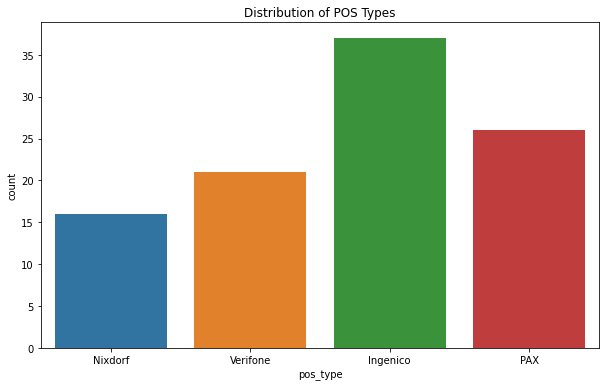

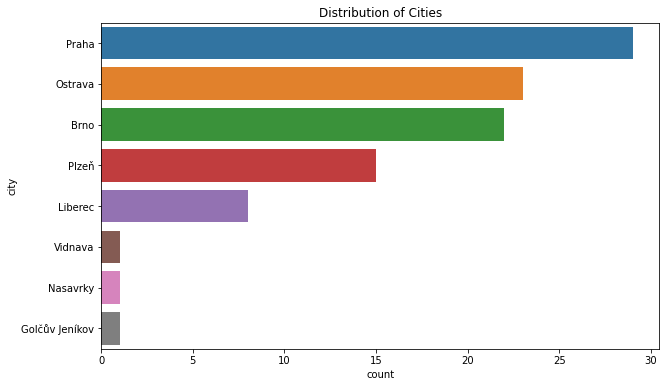

C:\Users\bartm\anaconda3\envs\demo\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


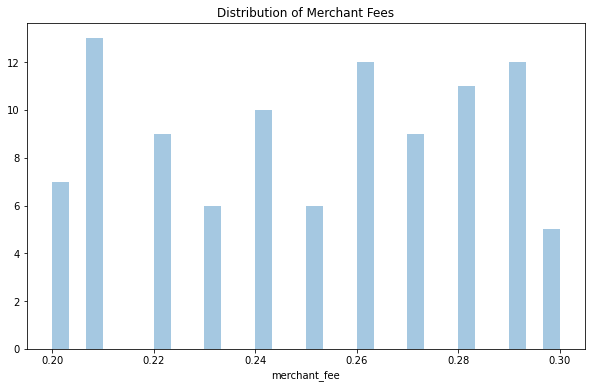

Number of unique merchants:  100
502853340    1
112285464    1
421812878    1
242341636    1
237577285    1
            ..
957498208    1
275383197    1
704297122    1
139277884    1
432437113    1
Name: merchant_id, Length: 100, dtype: int64


In [12]:
# code generated by chatgpt to do EDA
# Import necessary libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load the data
df = pd.read_csv('pos_data.csv', encoding='utf-8')

# Display the first few rows of the dataframe
print(df.head())

# Display the summary statistics of the dataframe
print(df.describe(include='all'))

# Display the data types of each column
print(df.dtypes)

# Check for missing values
print(df.isnull().sum())

# Plot the distribution of pos_type
plt.figure(figsize=(10,6))
sns.countplot(x='pos_type', data=df)
plt.title('Distribution of POS Types')
plt.show()

# Plot the distribution of cities
plt.figure(figsize=(10,6))
sns.countplot(y='city', data=df, order=df['city'].value_counts().index)
plt.title('Distribution of Cities')
plt.show()

# Plot the distribution of merchant fees
plt.figure(figsize=(10,6))
sns.distplot(df['merchant_fee'], kde=False, bins=30)
plt.title('Distribution of Merchant Fees')
plt.show()

# Display the number of unique merchants
print('Number of unique merchants: ', df['merchant_id'].nunique())

# Display the number of POS devices per merchant
print(df['merchant_id'].value_counts())

   id        pos_id  pos_type                                     address     city                bban                    iban  merchant_id              merchant_name  merchant_fee registered_date last_update_date
0   1  FRT226555418   Nixdorf         Jablonecká 8, 751 62 Lázně Kynžvart    Praha  WMPG80659947960745  GB39FDEL38375659554258    502853340  Dvořáková Beranová s.r.o.          0.26      2007-11-09       2023-04-11
1   2  GLA879447161  Verifone                   Paťanka 79, 420 16 Osečná    Praha  UPJA92114415975600  GB92PTQD38819271741859    150874212            Doležalová a.s.          0.28      2020-05-28       2023-02-28
2   3  BCI011172915  Ingenico         Makedonská 90, 757 33 Horšovský Týn     Brno  JZME71114388186515  GB03VACA60070312388275    994307389       Krejčí Benešová a.s.          0.26      1993-07-03       2023-05-26
3   4  VHK972942455  Verifone                 Na Šubě 375, 130 55 Miletín  Liberec  HFCC66787431581270  GB90GUAN60818272676745    897680659     

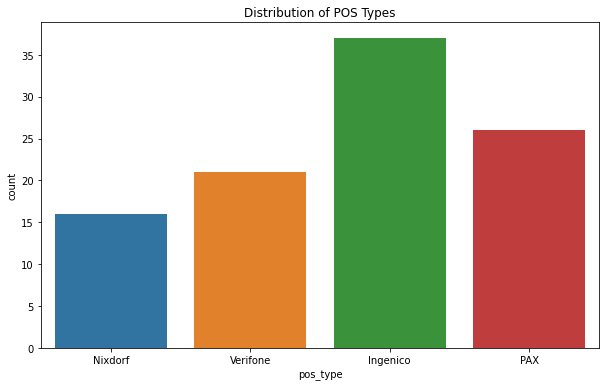

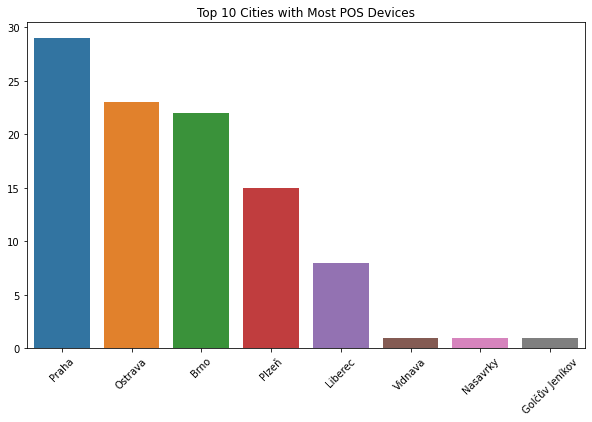

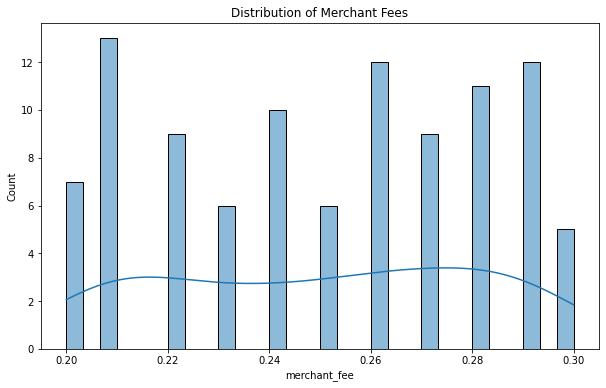

Earliest registered date: 1991-10-24
Latest registered date: 2022-06-23
Earliest update date: 2022-09-19
Latest update date: 2023-09-19


In [13]:
# code generated by chatgpt to do EDA - another model response
# Import necessary libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load the data
df = pd.read_csv('pos_data.csv', encoding='utf-8')

# Display the first few rows of the dataframe
print(df.head())

# Display the summary statistics of the dataframe
print(df.describe(include='all'))

# Display the data types of each column
print(df.dtypes)

# Check for missing values
print(df.isnull().sum())

# Count the number of unique values in each column
for col in df.columns:
    print(f'{col}: {df[col].nunique()} unique values')

# Plot the distribution of pos_type
plt.figure(figsize=(10,6))
sns.countplot(data=df, x='pos_type')
plt.title('Distribution of POS Types')
plt.show()

# Plot the top 10 cities with the most POS devices
top_cities = df['city'].value_counts().head(10)
plt.figure(figsize=(10,6))
sns.barplot(x=top_cities.index, y=top_cities.values)
plt.title('Top 10 Cities with Most POS Devices')
plt.xticks(rotation=45)
plt.show()

# Plot the distribution of merchant fees
plt.figure(figsize=(10,6))
sns.histplot(data=df, x='merchant_fee', bins=30, kde=True)
plt.title('Distribution of Merchant Fees')
plt.show()

# Display the earliest and latest registered dates
print(f"Earliest registered date: {df['registered_date'].min()}")
print(f"Latest registered date: {df['registered_date'].max()}")

# Display the earliest and latest update dates
print(f"Earliest update date: {df['last_update_date'].min()}")
print(f"Latest update date: {df['last_update_date'].max()}")

## 3. Kontrola datové kvalita

Následující ukázka demnostruje jak využít gpt model ke generování skriptů za účelem kontroly datové kvality.<br>
Pro tuto úlohu je potřeba definovat prompt s následujícími instrukcemi:
- co je datový vstup (např. pos_data.csv file)
- co je očekáváný výstup (např. generate python script that ...)
- jak výstupy prezentovat/exportovat (tisk do konzole, export do souboru, logging library)
- seznam datových kontrol, které má skript provést, viz prompt níže

In [14]:
# prompt to generated script for DQ checks
# it takes about 50 sec to get model response
prompt=[
    {
      "role": "system",
      "content": "You are helpful assistant which generates python script for jupyter notebook."
    },
    {
      "role": "user",
      "content": """Generate python script which will do data quality checks on pos_data.csv file.
                    Print results of data quality checks into python console.
                    Also save results into dq_checks_{current_date_time}.txt file.
                    Here is the list of the data quality checks:
                    1) id value (integer) is unique for every  record. If not raise Error 01 and list id of the record.
                    2) pos_id value (string) is unique for every record. If not raise Error 02 and list id of the record.
                    3) pos_id value (string) is 12 characters long. If not raise Error 03 and list id of the record.
                    4) merchant_id (integer) is 9 characters long. If not raise Error 04 and list id of the record.
                    5) registered_date (object) is between 1990 and current date. If not raise Error 05 and list id of the record."""
    }
  ]
ask_chatgpt(prompt)

INFO:root:Model response took: 0:00:48.492938


Here is the Python script that performs the data quality checks you requested:

```python
import pandas as pd
from datetime import datetime

# Load the data
df = pd.read_csv('pos_data.csv')

# Initialize an empty list to store error messages
errors = []

# Check 1: id value is unique
if df['id'].nunique() != len(df):
    duplicates = df[df['id'].duplicated()]['id'].tolist()
    errors.append(f"Error 01: Duplicate IDs found: {duplicates}")

# Check 2: pos_id value is unique
if df['pos_id'].nunique() != len(df):
    duplicates = df[df['pos_id'].duplicated()]['id'].tolist()
    errors.append(f"Error 02: Duplicate pos_id found: {duplicates}")

# Check 3: pos_id value is 12 characters long
if not all(df['pos_id'].str.len() == 12):
    incorrect_length = df[df['pos_id'].str.len() != 12]['id'].tolist()
    errors.append(f"Error 03: Incorrect pos_id length: {incorrect_length}")

# Check 4: merchant_id is 9 characters long
if not all(df['merchant_id'].astype(str).str.len() == 9):
    incorrect_

Odpoveď modelu zkopírujte níže a pusťte skript.<br>
Skript vytiskne výčet chyb do konzole a uložího do souboru dq_checks_{current_date_time}.txt<br>
Pokud skript žádné chyby nevrátí, pravděpodobně nejsou přítomny v testovaném souboru.<br>
Otevřte testovaný soubor pos_data.csv, zaneste tam nějaké chyby a skript pusťte znovu.

In [15]:
# code generated by chatgpt to do DQ checks
import pandas as pd
from datetime import datetime

# Load the data
df = pd.read_csv('pos_data.csv')

# Initialize an empty list to store error messages
errors = []

# Check 1: id value is unique
if df['id'].nunique() != len(df):
    duplicates = df[df['id'].duplicated()]['id'].tolist()
    errors.append(f"Error 01: Duplicate IDs found: {duplicates}")

# Check 2: pos_id value is unique
if df['pos_id'].nunique() != len(df):
    duplicates = df[df['pos_id'].duplicated()]['id'].tolist()
    errors.append(f"Error 02: Duplicate pos_id found: {duplicates}")

# Check 3: pos_id value is 12 characters long
if not all(df['pos_id'].str.len() == 12):
    incorrect_length = df[df['pos_id'].str.len() != 12]['id'].tolist()
    errors.append(f"Error 03: Incorrect pos_id length: {incorrect_length}")

# Check 4: merchant_id is 9 characters long
if not all(df['merchant_id'].astype(str).str.len() == 9):
    incorrect_length = df[df['merchant_id'].astype(str).str.len() != 9]['id'].tolist()
    errors.append(f"Error 04: Incorrect merchant_id length: {incorrect_length}")

# Check 5: registered_date is between 1990 and current date
df['registered_date'] = pd.to_datetime(df['registered_date'])
if not all((df['registered_date'] > '1990-01-01') & (df['registered_date'] < datetime.now())):
    incorrect_dates = df[~((df['registered_date'] > '1990-01-01') & (df['registered_date'] < datetime.now()))]['id'].tolist()
    errors.append(f"Error 05: Incorrect registered_date: {incorrect_dates}")

# Print errors to console
for error in errors:
    print(error)

# Save errors to a text file
with open(f"dq_checks_{datetime.now().strftime('%Y%m%d_%H%M%S')}.txt", 'w') as f:
    for error in errors:
        f.write(error + '\n')

## 4. Generování dokumentace

### Convert CSV file to JSON

Další use case ukáže, jak využít gpt model ke generování dokumentace.<br>
Je důležité modelu předat instrukce:
- jaký typ dokumentace má generovat (db model, dokumentace kódu, business dokumentace)
- v jakém formátu očekáváte výstup (SQL, DBML, Python code with docstrings - reST, HTML)
- uvést příklad u jednoho či více záznamů

V příkladu níže generuji DBML dokumentaci na základě vstupů ze souboru db_input.csv.<br>
Pro práci s gpt modelem potřebuji db_input_csv převést na json file, využiju gpt ke generování potřebné python funkce.<br>

In [17]:
# prompt to convert csv file to json file with python
prompt=[
    {
      "role": "system",
      "content": "You are helpful assistant which generates python script for jupyter notebook."
    },
    {
      "role": "user",
      "content": "Generate python script which will load db_input.csv file with \";\" delimiter and utf-8 encoding and save it to json with intendation."
    }
  ]
ask_chatgpt(prompt)

INFO:root:Model response took: 0:00:18.648407


Sure, here is a Python script that will load a CSV file and save it as a JSON file:

```python
# Importing required libraries
import pandas as pd
import json

# Load the csv file
df = pd.read_csv('db_input.csv', delimiter=';', encoding='utf-8')

# Save the dataframe to json format
df.to_json('db_output.json', orient='records', lines=True, indent=4)

print("CSV file has been successfully converted to JSON.")
```

This script will create a JSON file named 'db_output.json'. The 'orient' parameter is set to 'records' which means the JSON string will be line delimited. The 'lines' parameter is set to True which means the JSON object will be written per line. The 'indent' parameter is set to 4 which means to use that many spaces for indentation.


In [19]:
# Script generated by gpt model
# Importing required libraries
import pandas as pd
import json

# Load the csv file
df = pd.read_csv('db_input.csv', delimiter=';', encoding='utf-8')

# Save the dataframe to json format
df.to_json('db_input.json', orient='records', lines=True, indent=4)

print("CSV file has been successfully converted to JSON.")

CSV file has been successfully converted to JSON.


### Generate DBML

Následující prompt dává instrukci aby gpt model vygeneroval DBML diagram tabulky POS_DEVICE na základě inputu ze souboru db_input.json

In [20]:
prompt=[
    {
      "role": "system",
      "content": "You are helpful assistant which generates DBML for dbdiagram.io based on JSON input"
    },
    {
      "role": "user",
      "content": """Generate DBML of POS_DEVICE table based on following input:
      
    {
        "index":0,
        "attribute name":"ID",
        "attribute description":"id of the record",
        "datatype":"INT"
    }

    {
        "index":1,
        "attribute name":"POS_ID",
        "attribute description":"id of the POS device",
        "datatype":"VARCHAR(9)"
    }

    {
        "index":2,
        "attribute name":"POS_TYPE",
        "attribute description":"type of the POS device",
        "datatype":"VARCHAR(255)"
    }

    {
        "index":3,
        "attribute name":"ADDRESS",
        "attribute description":"address of the POS device",
        "datatype":"VARCHAR(255)"
    }

    {
        "index":4,
        "attribute name":"CITY",
        "attribute description":"city where POS device is located",
        "datatype":"VARCHAR(255)"
    }

    {
        "index":5,
        "attribute name":"BBAN",
        "attribute description":"Basic Bank Account number of the POS device",
        "datatype":"VARCHAR(255)"
    }

    {
        "index":6,
        "attribute name":"IBAN",
        "attribute description":"International Bank account number of the POS device",
        "datatype":"VARCHAR(255)"
    }

    {
        "index":7,
        "attribute name":"MERCHANT_ID",
        "attribute description":"id of the Merchant which POS device is registered to",
        "datatype":"VARCHAR(9)"
    }

    {
        "index":8,
        "attribute name":"MERCHANT_NAME",
        "attribute description":"name of the merchant which POS device is registered to",
        "datatype":"VARCHAR(255)"
    }

    {
        "index":9,
        "attribute name":"MERCHANT_FEE",
        "attribute description":"fee that merchant pays for every payment done via POS device",
        "datatype":"FLOAT"
    }

    {
        "index":10,
        "attribute name":"REGISTERED_DATE",
        "attribute description":"date when POS device was registered",
        "datatype":"DATE"
    }

    {
        "index":11,
        "attribute name":"LAST_UPDATE_DATE",
        "attribute description":"date of last update of the record",
        "datatype":"DATE"
    }


        """
    }
  ]
ask_chatgpt(prompt)

INFO:root:Model response took: 0:00:26.039133


Here is the DBML for the POS_DEVICE table:

```dbml
Table POS_DEVICE {
  ID INT [note: 'id of the record']
  POS_ID VARCHAR(9) [note: 'id of the POS device']
  POS_TYPE VARCHAR(255) [note: 'type of the POS device']
  ADDRESS VARCHAR(255) [note: 'address of the POS device']
  CITY VARCHAR(255) [note: 'city where POS device is located']
  BBAN VARCHAR(255) [note: 'Basic Bank Account number of the POS device']
  IBAN VARCHAR(255) [note: 'International Bank account number of the POS device']
  MERCHANT_ID VARCHAR(9) [note: 'id of the Merchant which POS device is registered to']
  MERCHANT_NAME VARCHAR(255) [note: 'name of the merchant which POS device is registered to']
  MERCHANT_FEE FLOAT [note: 'fee that merchant pays for every payment done via POS device']
  REGISTERED_DATE DATE [note: 'date when POS device was registered']
  LAST_UPDATE_DATE DATE [note: 'date of last update of the record']
}
```
This DBML defines a table named POS_DEVICE with 12 columns. Each column has a specific dat

### Generate DBML - Adding Bank_Account and Merchant

Následující prompt přidává do stejné instrukci další objekty, tabulku BANK_ACCOUNT a tabulku MERCHANT.

In [21]:
prompt=[
    {
      "role": "system",
      "content": "You are helpful assistant which generates DBML for dbdiagram.io based on JSON input"
    },
    {
      "role": "user",
      "content": """Generate DBML of POS_DEVICE table based on following input:
      
    {
        "index":0,
        "attribute name":"ID",
        "attribute description":"id of the record",
        "datatype":"INT"
    }

    {
        "index":1,
        "attribute name":"POS_ID",
        "attribute description":"id of the POS device",
        "datatype":"VARCHAR(9)"
    }

    {
        "index":2,
        "attribute name":"POS_TYPE",
        "attribute description":"type of the POS device",
        "datatype":"VARCHAR(255)"
    }

    {
        "index":3,
        "attribute name":"ADDRESS",
        "attribute description":"address of the POS device",
        "datatype":"VARCHAR(255)"
    }

    {
        "index":4,
        "attribute name":"CITY",
        "attribute description":"city where POS device is located",
        "datatype":"VARCHAR(255)"
    }

    {
        "index":5,
        "attribute name":"BBAN",
        "attribute description":"Basic Bank Account number of the POS device",
        "datatype":"VARCHAR(255)"
    }

    {
        "index":6,
        "attribute name":"IBAN",
        "attribute description":"International Bank account number of the POS device",
        "datatype":"VARCHAR(255)"
    }

    {
        "index":7,
        "attribute name":"MERCHANT_ID",
        "attribute description":"id of the Merchant which POS device is registered to",
        "datatype":"VARCHAR(9)"
    }

    {
        "index":8,
        "attribute name":"MERCHANT_NAME",
        "attribute description":"name of the merchant which POS device is registered to",
        "datatype":"VARCHAR(255)"
    }

    {
        "index":9,
        "attribute name":"MERCHANT_FEE",
        "attribute description":"fee that merchant pays for every payment done via POS device",
        "datatype":"FLOAT"
    }

    {
        "index":10,
        "attribute name":"REGISTERED_DATE",
        "attribute description":"date when POS device was registered",
        "datatype":"DATE"
    }

    {
        "index":11,
        "attribute name":"LAST_UPDATE_DATE",
        "attribute description":"date of last update of the record",
        "datatype":"DATE"
    }


        """
    },
     {
      "role": "user",
      "content": """Add into DBML table BANK_ACCOUNT which will contain BBAN and IBAN with relation POS_DATA.BBAN - BANK_ACCOUNT.BBAN. 
        Add table MERCHANT that will contain fields MERCHANT_ID, MERCHANT_NAME, MERCHANT_FEE with relation POS_DATA.MERCHANT_ID > MERCHANT.MERCHANT_ID"""
    }
  ]
ask_chatgpt(prompt)

INFO:root:Model response took: 0:00:36.539587


Here is the DBML code for the tables POS_DEVICE, BANK_ACCOUNT, and MERCHANT:

```dbml
Table POS_DEVICE {
  ID INT [pk, note: 'id of the record']
  POS_ID VARCHAR(9) [note: 'id of the POS device']
  POS_TYPE VARCHAR(255) [note: 'type of the POS device']
  ADDRESS VARCHAR(255) [note: 'address of the POS device']
  CITY VARCHAR(255) [note: 'city where POS device is located']
  BBAN VARCHAR(255) [note: 'Basic Bank Account number of the POS device']
  IBAN VARCHAR(255) [note: 'International Bank account number of the POS device']
  MERCHANT_ID VARCHAR(9) [note: 'id of the Merchant which POS device is registered to']
  MERCHANT_NAME VARCHAR(255) [note: 'name of the merchant which POS device is registered to']
  MERCHANT_FEE FLOAT [note: 'fee that merchant pays for every payment done via POS device']
  REGISTERED_DATE DATE [note: 'date when POS device was registered']
  LAST_UPDATE_DATE DATE [note: 'date of last update of the record']
}

Table BANK_ACCOUNT {
  BBAN VARCHAR(255) [pk, note: 'Ba

DBML kód si zkopírujte <br>
Otevřete prohlížeč a zadejte [dbdiagram.io](https://dbdiagram.io)<br>
Klikněte na "create your diagram"<br>
Otevře se Vám stránka kam na levé straně vložíte DBML kód a na pravé straně se Vám vygeneruje DB diagram


### Generate HTML

Prompt níže generuje dokumentaci jako HTML stránku.<br>
Výsledný HTML kód vložte do textového editoru a soubor uložte jako documentation.html.<br>

In [22]:
prompt=[
    {
      "role": "system",
      "content": "You are helpful assistant which generates HTML documentation for database objects based on json input. "
    },
    {
      "role": "user",
      "content": """Generate HTML documentation named pos_device.html based on following input:
      
    {
        "index":0,
        "attribute name":"ID",
        "attribute description":"id of the record",
        "datatype":"INT"
    }

    {
        "index":1,
        "attribute name":"POS_ID",
        "attribute description":"id of the POS device",
        "datatype":"VARCHAR(9)"
    }

    {
        "index":2,
        "attribute name":"POS_TYPE",
        "attribute description":"type of the POS device",
        "datatype":"VARCHAR(255)"
    }

    {
        "index":3,
        "attribute name":"ADDRESS",
        "attribute description":"address of the POS device",
        "datatype":"VARCHAR(255)"
    }

    {
        "index":4,
        "attribute name":"CITY",
        "attribute description":"city where POS device is located",
        "datatype":"VARCHAR(255)"
    }

    {
        "index":5,
        "attribute name":"BBAN",
        "attribute description":"Basic Bank Account number of the POS device",
        "datatype":"VARCHAR(255)"
    }

    {
        "index":6,
        "attribute name":"IBAN",
        "attribute description":"International Bank account number of the POS device",
        "datatype":"VARCHAR(255)"
    }

    {
        "index":7,
        "attribute name":"MERCHANT_ID",
        "attribute description":"id of the Merchant which POS device is registered to",
        "datatype":"VARCHAR(9)"
    }

    {
        "index":8,
        "attribute name":"MERCHANT_NAME",
        "attribute description":"name of the merchant which POS device is registered to",
        "datatype":"VARCHAR(255)"
    }

    {
        "index":9,
        "attribute name":"MERCHANT_FEE",
        "attribute description":"fee that merchant pays for every payment done via POS device",
        "datatype":"FLOAT"
    }

    {
        "index":10,
        "attribute name":"REGISTERED_DATE",
        "attribute description":"date when POS device was registered",
        "datatype":"DATE"
    }

    {
        "index":11,
        "attribute name":"LAST_UPDATE_DATE",
        "attribute description":"date of last update of the record",
        "datatype":"DATE"
    }


        """
    }
  ]
ask_chatgpt(prompt)

INFO:root:Model response took: 0:01:05.384590


<!DOCTYPE html>
<html>
<head>
    <title>POS Device Documentation</title>
    <style>
        table {
            width: 100%;
            border-collapse: collapse;
        }
        th, td {
            border: 1px solid black;
            padding: 15px;
            text-align: left;
        }
        th {
            background-color: #4CAF50;
            color: white;
        }
    </style>
</head>
<body>
    <h1>POS Device Documentation</h1>
    <table>
        <tr>
            <th>Index</th>
            <th>Attribute Name</th>
            <th>Attribute Description</th>
            <th>Data Type</th>
        </tr>
        <tr>
            <td>0</td>
            <td>ID</td>
            <td>id of the record</td>
            <td>INT</td>
        </tr>
        <tr>
            <td>1</td>
            <td>POS_ID</td>
            <td>id of the POS device</td>
            <td>VARCHAR(9)</td>
        </tr>
        <tr>
            <td>2</td>
            <td>POS_TYPE</td>
            <td>ty

### Generate markdown documentation

Následující prompt generuje dokumentaci ve formátu markdown.

In [23]:
prompt=[
    {
      "role": "system",
      "content": "You are helpful assistant which generates markdown documentation for database objects based on json input. "
    },
    {
      "role": "user",
      "content": """Generate markdown documentation about POS_DEVICE table based on following input:
      
    {
        "index":0,
        "attribute name":"ID",
        "attribute description":"id of the record",
        "datatype":"INT"
    }

    {
        "index":1,
        "attribute name":"POS_ID",
        "attribute description":"id of the POS device",
        "datatype":"VARCHAR(9)"
    }

    {
        "index":2,
        "attribute name":"POS_TYPE",
        "attribute description":"type of the POS device",
        "datatype":"VARCHAR(255)"
    }

    {
        "index":3,
        "attribute name":"ADDRESS",
        "attribute description":"address of the POS device",
        "datatype":"VARCHAR(255)"
    }

    {
        "index":4,
        "attribute name":"CITY",
        "attribute description":"city where POS device is located",
        "datatype":"VARCHAR(255)"
    }

    {
        "index":5,
        "attribute name":"BBAN",
        "attribute description":"Basic Bank Account number of the POS device",
        "datatype":"VARCHAR(255)"
    }

    {
        "index":6,
        "attribute name":"IBAN",
        "attribute description":"International Bank account number of the POS device",
        "datatype":"VARCHAR(255)"
    }

    {
        "index":7,
        "attribute name":"MERCHANT_ID",
        "attribute description":"id of the Merchant which POS device is registered to",
        "datatype":"VARCHAR(9)"
    }

    {
        "index":8,
        "attribute name":"MERCHANT_NAME",
        "attribute description":"name of the merchant which POS device is registered to",
        "datatype":"VARCHAR(255)"
    }

    {
        "index":9,
        "attribute name":"MERCHANT_FEE",
        "attribute description":"fee that merchant pays for every payment done via POS device",
        "datatype":"FLOAT"
    }

    {
        "index":10,
        "attribute name":"REGISTERED_DATE",
        "attribute description":"date when POS device was registered",
        "datatype":"DATE"
    }

    {
        "index":11,
        "attribute name":"LAST_UPDATE_DATE",
        "attribute description":"date of last update of the record",
        "datatype":"DATE"
    }


        """
    }
  ]
ask_chatgpt(prompt)

INFO:root:Model response took: 0:00:28.679493


# POS_DEVICE Table

This table contains information about the Point of Sale (POS) devices.

## Table Attributes

1. **ID** (INT): This is the id of the record.
2. **POS_ID** (VARCHAR(9)): This is the id of the POS device.
3. **POS_TYPE** (VARCHAR(255)): This attribute represents the type of the POS device.
4. **ADDRESS** (VARCHAR(255)): This attribute holds the address of the POS device.
5. **CITY** (VARCHAR(255)): This attribute indicates the city where the POS device is located.
6. **BBAN** (VARCHAR(255)): This attribute is the Basic Bank Account number of the POS device.
7. **IBAN** (VARCHAR(255)): This attribute is the International Bank account number of the POS device.
8. **MERCHANT_ID** (VARCHAR(9)): This attribute is the id of the Merchant which the POS device is registered to.
9. **MERCHANT_NAME** (VARCHAR(255)): This attribute is the name of the merchant which the POS device is registered to.
10. **MERCHANT_FEE** (FLOAT): This attribute is the fee that the merchant pays for e

# Tips and tricks

- GPT modely jsou skvělý pomocník pro inicální fáze Vašich projektů. Lepší je je použít na začátku pro jednoduché úkoly, než se je snažit implementovat na komplexní úlohy.
- Nesnažte se model instruovat, aby splnil několik úloh současně. Např. analyzuj + exportuj + vizualizuj data. Lepší je úlohu rozdělit na 3 samostatné úlohy - prompty.
- Vždycky modelu poskytněte strukturované vstupy, kontext (účelu, úlohy, dat apod), příklady řešení. Takto dosáhnete nejlepších výsledků.
- Model GPT4 se chová nedeterministicky. Pokud chcete omezit náhodnost výsledku, musíte nastavit model na Temperature = 0, použít jasné instrukce, uvést příklad, popř. definovat list zakázaných odpovědí.
- Kód, který generuje GPT model není vždy 100% funkční! Většinou se jedná o drobné chyby, ale i tak mu nedávejte 100% důvěru. Je to pomocník, ne náhrada za analytika/developera.